# Bone Metastasis Classification using ResNet

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Load Data

In [2]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [3]:
# Data augmentation and normalization according to the ResNet configuration
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = 'dataset-resnet/'
batches = 10

In [5]:
image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir + 'train', data_transforms['train']),
    'test': 
    datasets.ImageFolder(data_dir + 'test', data_transforms['test'])
}

In [6]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batches,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batches,
                                shuffle=True,
                                num_workers=0)
}

### Define Model

In [7]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [8]:
# Load ResNet50 model
model = models.resnet50(pretrained=True).to(device)

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

In [11]:
# Define criterion (function used to compute loss) and optimizer for model
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

### Train Model

In [12]:
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [13]:
model_trained = train_model(model, criterion, optimizer, num_epochs=90)

Epoch 1/90
----------
train loss: 0.6391, acc: 0.6544
test loss: 0.6256, acc: 0.6898
Epoch 2/90
----------
train loss: 0.5982, acc: 0.6871
test loss: 0.6064, acc: 0.7673
Epoch 3/90
----------
train loss: 0.5932, acc: 0.6809
test loss: 0.6067, acc: 0.7143
Epoch 4/90
----------
train loss: 0.5736, acc: 0.6993
test loss: 0.7156, acc: 0.4980
Epoch 5/90
----------
train loss: 0.5609, acc: 0.7125
test loss: 0.6499, acc: 0.6082
Epoch 6/90
----------
train loss: 0.5622, acc: 0.7217
test loss: 0.5400, acc: 0.7469
Epoch 7/90
----------
train loss: 0.5458, acc: 0.7390
test loss: 0.5767, acc: 0.7020
Epoch 8/90
----------
train loss: 0.5539, acc: 0.7268
test loss: 0.5416, acc: 0.7184
Epoch 9/90
----------
train loss: 0.5478, acc: 0.7482
test loss: 0.5657, acc: 0.6898
Epoch 10/90
----------
train loss: 0.5444, acc: 0.7329
test loss: 0.5748, acc: 0.7143
Epoch 11/90
----------
train loss: 0.5261, acc: 0.7554
test loss: 0.5521, acc: 0.7224
Epoch 12/90
----------
train loss: 0.5509, acc: 0.7299
test los

### Save Model

In [40]:
torch.save(model_trained.state_dict(), 'weights/resnet_weights.h5')

In [41]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('weights/resnet_weights.h5'))

<All keys matched successfully>

### Show Predictions on Sample Images

In [35]:
test_img_paths = [data_dir + "test/0/" + "0000-0-A.tif",
                  data_dir + "test/1/" + "0004-1-A.tif",
                  data_dir + "test/0/" + "0010-0-A.tif"]
test_ground_truths = ["No Metastasis", "Metastasis", "No Metastasis"]
img_list = [Image.open(img_path) for img_path in test_img_paths]

In [36]:
validation_batch = torch.stack([data_transforms['test'](img).to(device) for img in img_list])

In [37]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 1.6728, -0.9942],
        [-0.7756,  0.8839],
        [ 0.6249, -0.0807]], grad_fn=<AddmmBackward0>)

In [38]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.9350519 , 0.06494806],
       [0.15982743, 0.8401726 ],
       [0.66944045, 0.3305596 ]], dtype=float32)

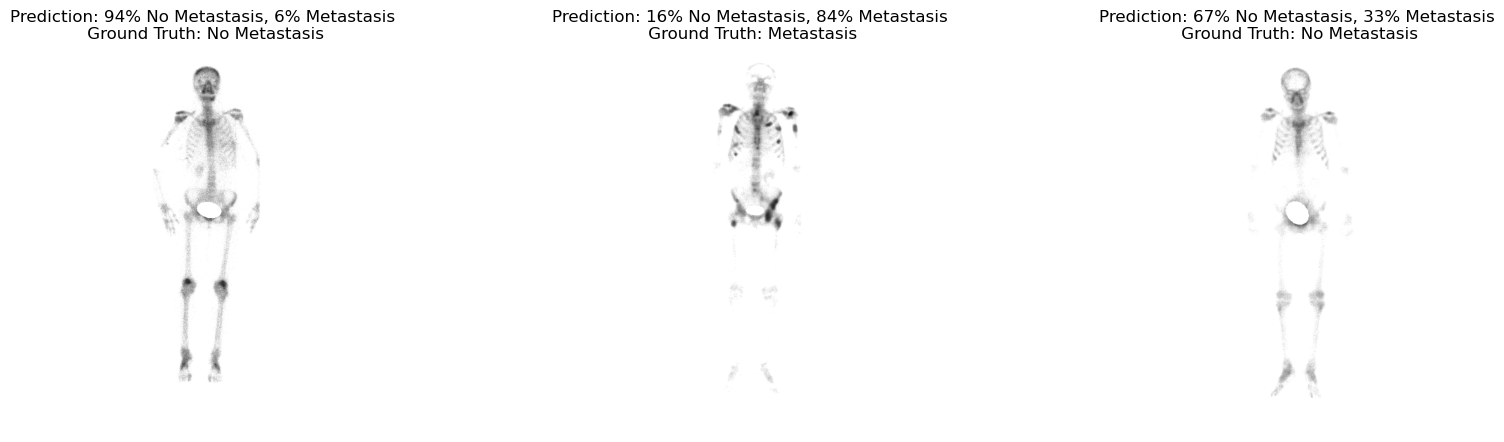

In [39]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis\n Ground Truth: {}"
                 .format(100*pred_probs[i,0], 100*pred_probs[i,1], test_ground_truths[i]))
    ax.imshow(img)